# Smear cross section with group velocity

This notebook reads in energy tables as output from `EnergyTabulator`, the transition rate as output from `LSF`, and the group velocities for different bands. It calculates the cross section using $$\sigma_i = \frac{\Gamma_i \Omega}{v_g^{(i)}}$$ then smears the cross section using Gaussians with widths $\nu$ defined as $$\nu = \hbar v_g^{(i)} \Delta k,$$ where $\Delta k$ is the distance between points on the k-mesh.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
HBAR = 6.582e-16  # Planck constant divided by 2π, in eV·s
A0 = 5.46836113565  # Bohr radius in Angstroms
A = 4*A0
A_CM = A*1e-8  # Unit: cm
DK = 2*np.pi/A_CM  # Unit: cm^-1
MASS_ELEC = 9.1093837015e-31 # kg
EV_TO_J = 1.60218e-19

### Set up helper functions

The `gaussian` function generates the value of a Gaussian function centered at `mu` with width `sigma`, evaluated at a point `x`.

In [2]:
def gaussian(x, sigma, mu):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

The `gaussian_smearing_with_vg` function takes `x` and `y` values and smears the `y` values across the `x` axis based on the group velocities. Each band has its own group velocity, which defines how much a single point affects the points around it (i.e., the width of its Gaussian). 

A Gaussian is defined for each `y` value, centered at the corresponding `x` value. The outer loop iterates through `x` and evaluates all of the Gaussians at a given point `xi`. The total weight is normalized, and each raw `y` value contributes to a `smeared_y` value based on its weight as evaluated at the given `xi`. 

*Points with a zero group velocity are given a weight of zero.*

In [3]:
def gaussian_smearing_with_vg(x, y, vgs,scale):
    sigmas = [HBAR * vg * DK*scale for vg in vgs]  # Calculate sigmas based on group velocities
    smeared_y = np.zeros_like(y)
    for i, xi in enumerate(x):
        new_y = 0
        tot_wt = 0
        for y_i, sigma, mu in zip(y, sigmas, x):
            if sigma != 0:
                wt = gaussian(xi, sigma, mu)
            else:
                wt = 0.0
            new_y += wt * y_i
            tot_wt += wt
        smeared_y[i] = new_y / tot_wt
    return smeared_y

## Define data

Define the total number of k-points and the spin index of interest.

In [4]:
num_k_points = 27
isp = 1

Read in the plotting energy from the energy table files for all k-points.

In [5]:
ENERGY_PATH = '../posToNeut/EnergyTabulator/'

dEPlot = []

# Read energies for each k-point
for ik in range(num_k_points):    
    file_path = f'{ENERGY_PATH}/energyTable.{isp}.{ik+1}'
    energyTable_k = np.loadtxt(file_path, skiprows=8)
    dEPlot.append(energyTable_k[:,5])

        
dEPlot = np.array(dEPlot)

Read in the zeroth-order transition rate for all k-points.

In [6]:
RATE0_PATH = '../posToNeut/zerothOrder/LSF/'

transitionRate0 = []

# Read transition rates for each k-point
for ik in range(num_k_points):
    file_path = f'{RATE0_PATH}/transitionRate.{isp}.{ik+1}'
    transitionRate_k = np.loadtxt(file_path, skiprows=5)
    transitionRate0.append(transitionRate_k[:,2])

        
transitionRate0 = np.array(transitionRate0)

Read in the zeroth-order matrix elements for all k-points. This is not needed for the cross section, but can be used for further exploration.

In [7]:
ME0_PATH = '../posToNeut/zerothOrder/TME/'

ME0 = []

# Read matrix elements for each k-point
for ik in range(num_k_points):
    file_path = f'{ME0_PATH}/allElecOverlap.{isp}.{ik+1}'
    ME0_k = np.loadtxt(file_path, skiprows=6)
    ME0.append(ME0_k[:,5])

        
ME0 = np.array(ME0).flatten()

Read in the $\Gamma$-only, first-order transition rate.

In [8]:
RATE1_PATH = '../posToNeut/firstOrder/LSF/'

file_path = f'{RATE1_PATH}/transitionRate.{isp}.1'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate1 = np.array(transitionRate_full[:,2])

Read in the group-velocity information. In Si, the group velocity was the same for all k-points with the same number of non-zero k-points (i.e., the same pattern). So I stored the group velocity for each kind of pattern (0/3, 1, and 2 nonzero coordinates) in a file called `gVelByPatt.txt`, then stored the pattern type for every k-point in `kTypeIndex` (0 and 3 are in the same group and are both called 0). 

Most of my group velocities were of the order $1\times10^{7}$. Because the group velocity is in the denominator, relatively small velocities can cause the data to spike. Instead, I just set lower velocities to zero based on a threshold so that those points would be given a weight of zero. **Make sure to update and/or remove the threshold based on your system.**

In [9]:
GVEL_PATH = '../../Si/groupVelocity/'

file_path = f'{GVEL_PATH}/gVelByPatt.txt'
gVelByPatt = np.array(np.loadtxt(file_path, skiprows=1))
gVelByPatt[gVelByPatt < 1e7] = 0.0

file_path = f'{GVEL_PATH}/kTypeIndex.txt'
kTypeIndex = np.array(np.loadtxt(file_path)).astype(int)

## Calculate cross section

This section calculates the unsmeared cross section based on the input data. The cell volume here is in cm$^3$, the group velocity is expected in cm/s, and the transition rate is expected in 1/s.

The cells below include lines to set the cross section of points that calculate to infinity (points with a zero group velocity) to zero so that they will not be given any weight in the smearing.

The group velocity must be flattened to go into the smearing functions later.

In [10]:
cellVol = 1.0465e-20 # cm^3

In [11]:
sigma0 = []
vg = []

for ik in range(num_k_points):
    sigma0_k = transitionRate0[ik]*cellVol/gVelByPatt[:,kTypeIndex[ik]]
    
    sigma0.append(sigma0_k)
    vg.append(gVelByPatt[:,kTypeIndex[ik]])

#print(sigma0)
sigma0 = np.array(sigma0).flatten()
sigma0[sigma0 == np.inf] = 0.0

vg = np.array(vg).flatten()

/tmp/ipykernel_2590/4016580789.py:5: RuntimeWarning: divide by zero encountered in divide
  sigma0_k = transitionRate0[ik]*cellVol/gVelByPatt[:,kTypeIndex[ik]]


In [12]:
sigma0[:10]

array([2.43360637e-17, 1.16885897e-17, 4.12902853e-17, 1.32740171e-17,
       3.62112258e-18, 6.21352715e-17, 6.30954973e-23, 1.07298362e-22,
       2.89840004e-17, 1.07088063e-18])

In [13]:
sigma1 = transitionRate1*cellVol/gVelByPatt[:,0]
sigma1[sigma1 == np.inf] = 0.0

/tmp/ipykernel_2590/2072214817.py:1: RuntimeWarning: divide by zero encountered in divide
  sigma1 = transitionRate1*cellVol/gVelByPatt[:,0]


## Smear and plot data

### Sort by energy

The plotting energy must be flattened and the data sorted by the energies in order before being input into the smearing function because that function assumes that the iteration through `x` is in order of energy. Otherwise, the Gaussians will not make any sense. We only need to do this because of the way multiple k-points are combined, so it is not needed for the $\Gamma$-only first-order term.

In [14]:
dEPlotFlat = dEPlot.flatten()

In [15]:
sort_indices = np.argsort(dEPlotFlat)

dEPlotFlat_sorted = np.array(dEPlotFlat.tolist())[sort_indices]
sigma0_sorted = np.array(sigma0.tolist())[sort_indices]
vg_sorted = np.array(vg.tolist())[sort_indices]
ME0_sorted = np.array(ME0.tolist())[sort_indices]

### Smear data

The `scale` parameter in the last argument is set by the $\Delta k$ distance between points in the k-mesh. The $\Gamma$-only energies and group velocities are used for the first-order term.

In [16]:
sigma0_smeared = gaussian_smearing_with_vg(dEPlotFlat_sorted, sigma0_sorted, vg_sorted, 1.0/3.0)

sigma1_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma1, gVelByPatt[:,0], 1)

### Plot

The cell below plots the zeroth- and first-order terms together on a semilog scale.

In [17]:
from matplotlib import ticker
from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=True)

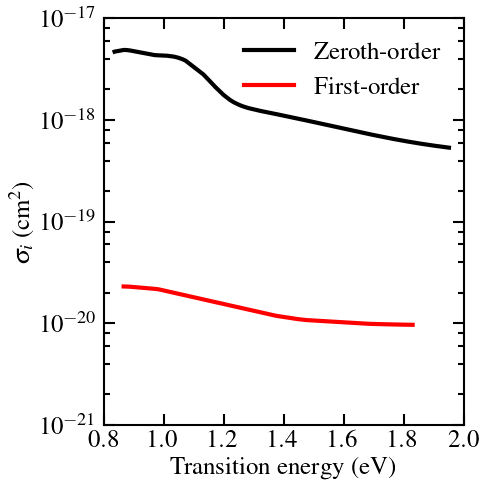

In [18]:
plt.figure(figsize=(5,5))

# Paper figure with smeared results
plt.semilogy(dEPlotFlat_sorted, sigma0_smeared, color='black', label='Zeroth-order', linewidth=3)#, marker='o', markersize=10)
plt.semilogy(dEPlot[0], sigma1_smeared, color='red', label='First-order', linewidth=3)#, marker='o', markersize=10)

# Raw data
#plt.semilogy(dEPlot, sigma0, color='black', label='Zeroth-order', marker='o', linestyle='', markersize=10)
#plt.semilogy(dEPlot, sigma1, color='red', label='First-order', marker='s', linestyle='', markersize=10)
#plt.plot(dEPlot, sigma0, color='black', label='Raw', marker='s', markersize=10, linestyle='None')

# Labels
plt.xlabel('Transition energy (eV)', fontsize=18)
plt.ylabel('$\sigma_i$ (cm$^2$)', fontsize=18)

# Plot formatting
plt.legend(loc='upper right', fontsize=18, frameon=False)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=18)  # Increase x-axis tick font size
plt.yticks(fontsize=18)  # Increase y-axis tick font size
plt.ylim(1e-21,1e-17)
plt.xlim(0.8,2.0)
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)   # Top border
ax.spines['right'].set_linewidth(1.5) # Right border
ax.spines['bottom'].set_linewidth(1.5)  # Bottom border (default width)
ax.spines['left'].set_linewidth(1.5)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='minor',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=1.5,  # Thickness of the tick marks
               length=4, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='major',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=1.5,  # Thickness of the tick marks
               length=8, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
plt.tight_layout()
plt.savefig('SiVH3_0th1st_posToNeut_20240229Laura.png',dpi=1200)
plt.show()

Plot the zeroth-order term on a linear scale.

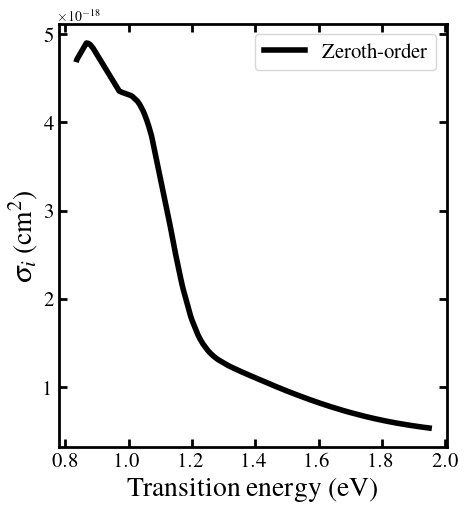

In [19]:
plt.figure(figsize=(5,5.5))

# Paper figure with smeared results
plt.plot(dEPlotFlat_sorted, sigma0_smeared, color='black', label='Zeroth-order', linewidth=4)#, marker='o', markersize=10)

# Labels
plt.xlabel('Transition energy (eV)', fontsize=20)
plt.ylabel('$\sigma_i$ (cm$^2$)', fontsize=20)

# Plot formatting
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0.9e-21,1e-17)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

### Matrix elements

Smear the matrix elements and plot

In [20]:
smeared_ME0_vg_posToNeut = gaussian_smearing_with_vg(dEPlotFlat_sorted, ME0_sorted, vg_sorted,0.22)

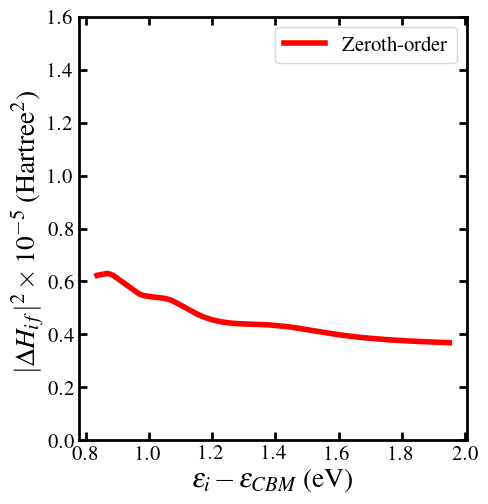

In [21]:
# Plot the smeared curve
plt.figure(figsize=(5,5.5))
plt.plot(dEPlotFlat_sorted, smeared_ME0_vg_posToNeut/1e-5, color='red', label='Zeroth-order',linewidth=4)
plt.xlabel(r'$\epsilon_i - \epsilon_{CBM}$ (eV)', fontsize=20)
plt.ylabel(r'$|\Delta H_{if}|^2 \times 10^{-5}$ (Hartree$^2$)', fontsize=20)
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
plt.ylim(0,1.6)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

### Compare with Barmparis

There are a lot of differences between our calculations and the Barmparis paper, but I would like to try to eliminate the differences between the way the group velocity was calculated and the use of an average matrix element previously. 

First, I calculate the classical $v_g = \sqrt{\frac{2E}{m}}$ converted to cm/s.

In [21]:
vg_classical = np.sqrt(2*(dEPlotFlat_sorted)*EV_TO_J/MASS_ELEC)*1e2

In [22]:
vg_classical

array([54236442.97530057, 54236442.97651965, 54236539.87584233, ...,
       82812367.0578065 , 82812499.93543084, 82812499.9354945 ])

Plot the velocities to show the difference.

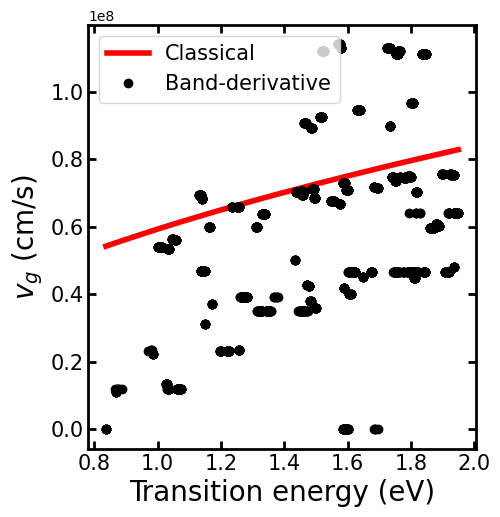

In [23]:
plt.figure(figsize=(5,5.5))
plt.plot(dEPlotFlat_sorted, vg_classical, color='red', label='Classical',linewidth=4)
plt.plot(dEPlotFlat_sorted, vg_sorted, color='black', label='Band-derivative',marker='o',linestyle='None')
plt.xlabel(r'Transition energy (eV)', fontsize=20)
plt.ylabel(r'$v_g$ (cm/s)', fontsize=20)
plt.legend(loc='upper left', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0,7)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

Divide by our matrix element and multiply by the matrix element used in the Barmparis paper.

In [24]:
transitionRate0Flat = transitionRate0.flatten()/ME0*0.3e-5

Sort transition rate by energy, then recalculate the cross section using the classical velocity.

In [25]:
transitionRate0Flat_sorted = np.array(transitionRate0Flat.tolist())[sort_indices]
sigma0Classical = transitionRate0Flat_sorted*cellVol/vg_classical
sigma0Classical[sigma0Classical == np.inf] = 0.0

Plot the results (smearing not needed because the matrix elements and group velocities are now continuous).

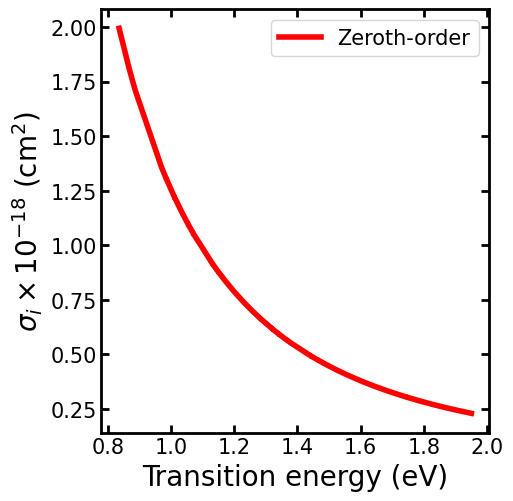

In [26]:
# Plot the smeared curve
plt.figure(figsize=(5,5.5))
#plt.plot(dEPlotFlat_sorted, smeared_sigma0_vg_posToNeut/1e-18, color='red', label='Zeroth-order',linewidth=4)
plt.plot(dEPlotFlat_sorted, sigma0Classical/1e-18, color='red', label='Zeroth-order',linewidth=4)
#plt.plot(dEPlotFlat_sorted, smeared_sigma0_vgClass/1e-19, color='red', label='Zeroth-order',linewidth=4)
plt.xlabel(r'Transition energy (eV)', fontsize=20)
plt.ylabel(r'$\sigma_i \times 10^{-18}$ (cm$^2$)', fontsize=20)
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0,7)
#plt.xlim(0.3,0.7)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

There are still clear differences. Our results are an order of magnitude smaller than the Barmparis results, and there is a significantly longer tail. There are so many differences, though, and there were several incorrect choices made in the Barmparis paper (e.g., the energies used and the positions of the atoms for the matrix elements), so the differences are okay. Our results do agree that the zeroth-order term dominates. 

## Compare results with different frequencies

We originally ran the code assuming that the initial and final frequencies were the same. One of the referees said that he thought it was important to account for possible differences in the initial and final frequencies. Compare the results with different random changes in the frequencies to get an idea of how sensitive the results are to the frequencies.

Load data.

In [23]:
RATE_PATH = '../posToNeut/zerothOrder/LSFDiffOmega/'

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.simplAlg'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_simpAlg = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.sameTwoOmega'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_sameTwoOmega = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.twoDiff10'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_twoDiff10 = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.twoDiff25'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_twoDiff25 = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.twoDiff50'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_twoDiff50 = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.plus50'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_plus50 = np.array(transitionRate_full[:,1])

file_path = f'{RATE_PATH}/transitionRate.{isp}.1.singlePlus50'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate_singlePlus50 = np.array(transitionRate_full[:,1])

Calculate cross section.

In [24]:
sigma_simpAlg = transitionRate_simpAlg*cellVol/gVelByPatt[:,0]
sigma_simpAlg[sigma_simpAlg == np.inf] = 0.0

sigma_sameTwoOmega = transitionRate_sameTwoOmega*cellVol/gVelByPatt[:,0]
sigma_sameTwoOmega[sigma_sameTwoOmega == np.inf] = 0.0

sigma_twoDiff10 = transitionRate_twoDiff10*cellVol/gVelByPatt[:,0]
sigma_twoDiff10[sigma_twoDiff10 == np.inf] = 0.0

sigma_twoDiff25 = transitionRate_twoDiff25*cellVol/gVelByPatt[:,0]
sigma_twoDiff25[sigma_twoDiff25 == np.inf] = 0.0

sigma_twoDiff50 = transitionRate_twoDiff50*cellVol/gVelByPatt[:,0]
sigma_twoDiff50[sigma_twoDiff50 == np.inf] = 0.0

sigma_plus50 = transitionRate_plus50*cellVol/gVelByPatt[:,0]
sigma_plus50[sigma_plus50 == np.inf] = 0.0

sigma_singlePlus50 = transitionRate_singlePlus50*cellVol/gVelByPatt[:,0]
sigma_singlePlus50[sigma_singlePlus50 == np.inf] = 0.0

/tmp/ipykernel_2590/1442675152.py:1: RuntimeWarning: divide by zero encountered in divide
  sigma_simpAlg = transitionRate_simpAlg*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:4: RuntimeWarning: divide by zero encountered in divide
  sigma_sameTwoOmega = transitionRate_sameTwoOmega*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:7: RuntimeWarning: divide by zero encountered in divide
  sigma_twoDiff10 = transitionRate_twoDiff10*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:10: RuntimeWarning: divide by zero encountered in divide
  sigma_twoDiff25 = transitionRate_twoDiff25*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:13: RuntimeWarning: divide by zero encountered in divide
  sigma_twoDiff50 = transitionRate_twoDiff50*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:16: RuntimeWarning: divide by zero encountered in divide
  sigma_plus50 = transitionRate_plus50*cellVol/gVelByPatt[:,0]
/tmp/ipykernel_2590/1442675152.py:19: RuntimeWa

Smear with the group velocities.

In [25]:
sigma_simpAlg_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_simpAlg, gVelByPatt[:,0], 1)
sigma_sameTwoOmega_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_sameTwoOmega, gVelByPatt[:,0], 1)
sigma_twoDiff10_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_twoDiff10, gVelByPatt[:,0], 1)
sigma_twoDiff25_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_twoDiff25, gVelByPatt[:,0], 1)
sigma_twoDiff50_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_twoDiff50, gVelByPatt[:,0], 1)
sigma_plus50_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_plus50, gVelByPatt[:,0], 1)
sigma_singlePlus50_smeared = gaussian_smearing_with_vg(dEPlot[0], sigma_singlePlus50, gVelByPatt[:,0], 1)

Plot results.

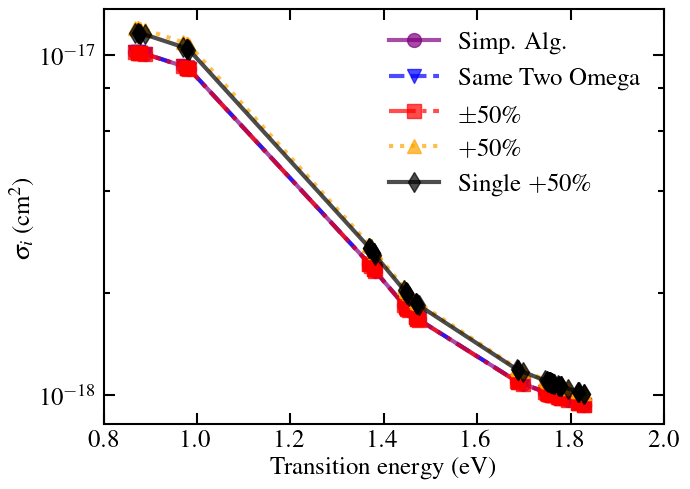

In [34]:
plt.figure(figsize=(7,5))

# Paper figure with smeared results
plt.semilogy(dEPlot[0], sigma_simpAlg_smeared, color='purple', label='Simp. Alg.', linewidth=3, marker='o', markersize=10, linestyle='-', alpha=0.7)
plt.semilogy(dEPlot[0], sigma_sameTwoOmega_smeared, color='blue', label='Same Two Omega', linewidth=3, marker='v', markersize=10, linestyle='--', alpha=0.7)
plt.semilogy(dEPlot[0], sigma_twoDiff50_smeared, color='red', label='$\pm 50\%$', linewidth=3, marker='s', markersize=10, linestyle='-.', alpha=0.7)
plt.semilogy(dEPlot[0], sigma_plus50_smeared, color='orange', label='$+50\%$', linewidth=3, marker='^', markersize=10, linestyle=':', alpha=0.7)
plt.semilogy(dEPlot[0], sigma_singlePlus50_smeared, color='black', label='Single $+50\%$', linewidth=3, marker='d', markersize=10, linestyle='-', alpha=0.7)

# Labels
plt.xlabel('Transition energy (eV)', fontsize=18)
plt.ylabel('$\sigma_i$ (cm$^2$)', fontsize=18)

# Plot formatting
plt.legend(loc='upper right', fontsize=18, frameon=False)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=18)  # Increase x-axis tick font size
plt.yticks(fontsize=18)  # Increase y-axis tick font size
#plt.ylim(1e-21,1e-17)
plt.xlim(0.8,2.0)
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)   # Top border
ax.spines['right'].set_linewidth(1.5) # Right border
ax.spines['bottom'].set_linewidth(1.5)  # Bottom border (default width)
ax.spines['left'].set_linewidth(1.5)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='minor',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=1.5,  # Thickness of the tick marks
               length=4, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='major',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=1.5,  # Thickness of the tick marks
               length=8, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
plt.tight_layout()
plt.savefig('SiVH3_diffOmegaComp_20240530Laura.png',dpi=1200)
plt.show()